# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4531.dev0+g638fca5
2.8.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict = True
ecc = True

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1475 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0647 seconds.
System internal structure set up in 0.0230 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


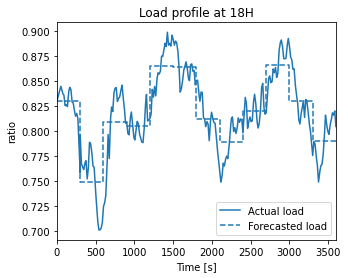

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0837 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.497456408
2: |F(x)| = 0.1830766442
3: |F(x)| = 0.0007183028614
4: |F(x)| = 1.659288396e-08
Converged in 5 iterations in 0.0049 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0047 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.497456408
2: |F(x)| = 0.1830766442
3: |F(x)| = 0.0007183028614
4: |F(x)| = 1.659288396e-08
Converged in 5 iterations in 0.0047 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778906, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 400

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [8]:
# sse.run(tf=caseH+1/3600, Pi=50,
#         is_updateA=False, is_rstate=True,
#         is_test=False, disable=True)

# sse.tsd['Prc'].iloc[1] - sse.tsd['Prc'].iloc[0]
# sse.tsd['Ptc'].iloc[1] - sse.tsd['Ptc'].iloc[0]
# sse.tsd['Pt'].iloc[1] - sse.tsd['Pt'].iloc[0]

# col = ['u', 'lc', 'agc', 'c', 'c0', 'na', 'nam', 'soc', 'socd']

# evc = sse.ev.copy()
# evc[evc['u'] == 1][col]
# evc[(evc['agc'] == 1) & (evc['lc'] == 1)][col]

SyntaxError: invalid syntax (1890325139.py, line 13)

In [ ]:
# col = ['u', 'lc', 'agc', 'c', 'c0', 'na', 'nam', 'soc', 'socd']

# evc = sse.ev.copy()
# evc[evc['u'] == 1][col]
# evc[(evc['agc'] == 1) & (evc['lc'] == 1)][col]
# evc[col].iloc[[5355, 7471, 14140]]

# sse.run(tf=caseH+50/3600, Pi=50,
#         is_updateA=False, is_rstate=True,
#         is_test=False, disable=True)
# sse.run(tf=caseH+100/3600, Pi=20,
#         is_updateA=False, is_rstate=True,
#         is_test=False, disable=True)
# sse.run(tf=caseH+150/3600, Pi=70,
#         is_updateA=False, is_rstate=True,
#         is_test=False, disable=True)

# sse.plot_agc()

In [9]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.957
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0041 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.451566076
2: |F(x)| = 0.1826707466
3: |F(x)| = 0.001144058568
4: |F(x)| = 3.262765791e-08
Converged in 5 iterations in 0.0064 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

nec= 12602
Pr= 4.491098845991609


Simulation to t=5.00 sec completed in 0.0314 seconds.
Simulation to t=6.00 sec completed in 0.0309 seconds.
Simulation to t=7.00 sec completed in 0.0307 seconds.
Simulation to t=8.00 sec completed in 0.0312 seconds.


nec= 12598
Pr= 6.075387599214464


Simulation to t=9.00 sec completed in 0.0315 seconds.
Simulation to t=10.00 sec completed in 0.0310 seconds.
Simulation to t=11.00 sec completed in 0.0296 seconds.
Simulation to t=12.00 sec completed in 0.0300 seconds.


nec= 12598
Pr= 9.057215316883436


Simulation to t=13.00 sec completed in 0.0362 seconds.
Simulation to t=14.00 sec completed in 0.0299 seconds.
Simulation to t=15.00 sec completed in 0.0290 seconds.
Simulation to t=16.00 sec completed in 0.0311 seconds.


nec= 12601
Pr= 11.560689437389604


Simulation to t=17.00 sec completed in 0.0280 seconds.
Simulation to t=18.00 sec completed in 0.0296 seconds.
Simulation to t=19.00 sec completed in 0.0304 seconds.
Simulation to t=20.00 sec completed in 0.0276 seconds.


nec= 12599
Pr= 14.150902095145446


Simulation to t=21.00 sec completed in 0.0308 seconds.
Simulation to t=22.00 sec completed in 0.0281 seconds.
Simulation to t=23.00 sec completed in 0.0274 seconds.
Simulation to t=24.00 sec completed in 0.0284 seconds.


nec= 12587
Pr= 16.73984523435562


Simulation to t=25.00 sec completed in 0.0287 seconds.
Simulation to t=26.00 sec completed in 0.0300 seconds.
Simulation to t=27.00 sec completed in 0.0282 seconds.
Simulation to t=28.00 sec completed in 0.0294 seconds.


nec= 12590
Pr= 19.334573548605505


Simulation to t=29.00 sec completed in 0.0275 seconds.
Simulation to t=30.00 sec completed in 0.0292 seconds.
Simulation to t=31.00 sec completed in 0.0290 seconds.
Simulation to t=32.00 sec completed in 0.0279 seconds.


nec= 12576
Pr= 21.93549900994081


Simulation to t=33.00 sec completed in 0.0296 seconds.
Simulation to t=34.00 sec completed in 0.0288 seconds.
Simulation to t=35.00 sec completed in 0.0305 seconds.
Simulation to t=36.00 sec completed in 0.0287 seconds.


nec= 12563
Pr= 24.593325165663522


Simulation to t=37.00 sec completed in 0.0299 seconds.
Simulation to t=38.00 sec completed in 0.0295 seconds.
Simulation to t=39.00 sec completed in 0.0288 seconds.
Simulation to t=40.00 sec completed in 0.0407 seconds.


nec= 12551
Pr= 34.13826504025596


Simulation to t=41.00 sec completed in 0.0302 seconds.
Simulation to t=42.00 sec completed in 0.0299 seconds.
Simulation to t=43.00 sec completed in 0.0295 seconds.
Simulation to t=44.00 sec completed in 0.0318 seconds.


nec= 12529
Pr= 34.91088143997936


Simulation to t=45.00 sec completed in 0.0298 seconds.
Simulation to t=46.00 sec completed in 0.0303 seconds.
Simulation to t=47.00 sec completed in 0.0288 seconds.
Simulation to t=48.00 sec completed in 0.0307 seconds.


nec= 12510
Pr= 37.63067327505136


Simulation to t=49.00 sec completed in 0.0309 seconds.
Simulation to t=50.00 sec completed in 0.0299 seconds.
Simulation to t=51.00 sec completed in 0.0306 seconds.
Simulation to t=52.00 sec completed in 0.0296 seconds.


nec= 12496
Pr= 39.21136692256001


Simulation to t=53.00 sec completed in 0.0292 seconds.
Simulation to t=54.00 sec completed in 0.0307 seconds.
Simulation to t=55.00 sec completed in 0.0307 seconds.
Simulation to t=56.00 sec completed in 0.0305 seconds.


nec= 12486
Pr= 38.792793676685925


Simulation to t=57.00 sec completed in 0.0303 seconds.
Simulation to t=58.00 sec completed in 0.0291 seconds.
Simulation to t=59.00 sec completed in 0.0291 seconds.
Simulation to t=60.00 sec completed in 0.0292 seconds.


nec= 12474
Pr= 38.18927424533999


Simulation to t=61.00 sec completed in 0.0303 seconds.
Simulation to t=62.00 sec completed in 0.0323 seconds.
Simulation to t=63.00 sec completed in 0.0319 seconds.
Simulation to t=64.00 sec completed in 0.0309 seconds.


nec= 12454
Pr= 36.80969232833683


Simulation to t=65.00 sec completed in 0.0292 seconds.
Simulation to t=66.00 sec completed in 0.0303 seconds.
Simulation to t=67.00 sec completed in 0.0308 seconds.
Simulation to t=68.00 sec completed in 0.0313 seconds.


nec= 12444
Pr= 35.21709946666887


Simulation to t=69.00 sec completed in 0.0300 seconds.
Simulation to t=70.00 sec completed in 0.0286 seconds.
Simulation to t=71.00 sec completed in 0.0302 seconds.
Simulation to t=72.00 sec completed in 0.0290 seconds.


nec= 12437
Pr= 33.30454754263647


Simulation to t=73.00 sec completed in 0.0321 seconds.
Simulation to t=74.00 sec completed in 0.0318 seconds.
Simulation to t=75.00 sec completed in 0.0294 seconds.
Simulation to t=76.00 sec completed in 0.0298 seconds.


nec= 12416
Pr= 31.32715434052141


Simulation to t=77.00 sec completed in 0.0323 seconds.
Simulation to t=78.00 sec completed in 0.0288 seconds.
Simulation to t=79.00 sec completed in 0.0296 seconds.
Simulation to t=80.00 sec completed in 0.0319 seconds.


nec= 12406
Pr= 23.504732976762934


Simulation to t=81.00 sec completed in 0.0299 seconds.
Simulation to t=82.00 sec completed in 0.0310 seconds.
Simulation to t=83.00 sec completed in 0.0305 seconds.
Simulation to t=84.00 sec completed in 0.0332 seconds.


nec= 12392
Pr= 23.803925603350592


Simulation to t=85.00 sec completed in 0.0298 seconds.
Simulation to t=86.00 sec completed in 0.0336 seconds.
Simulation to t=87.00 sec completed in 0.0331 seconds.
Simulation to t=88.00 sec completed in 0.0309 seconds.


nec= 12380
Pr= 22.461995289289835


Simulation to t=89.00 sec completed in 0.0305 seconds.
Simulation to t=90.00 sec completed in 0.0334 seconds.
Simulation to t=91.00 sec completed in 0.0320 seconds.
Simulation to t=92.00 sec completed in 0.0312 seconds.


nec= 12372
Pr= 21.835318652814514


Simulation to t=93.00 sec completed in 0.0298 seconds.
Simulation to t=94.00 sec completed in 0.0314 seconds.
Simulation to t=95.00 sec completed in 0.0315 seconds.
Simulation to t=96.00 sec completed in 0.0313 seconds.


nec= 12357
Pr= 18.044469266277297


Simulation to t=97.00 sec completed in 0.0324 seconds.
Simulation to t=98.00 sec completed in 0.0304 seconds.
Simulation to t=99.00 sec completed in 0.0292 seconds.
Simulation to t=100.00 sec completed in 0.0327 seconds.


nec= 12353
Pr= 14.493748218876616


Simulation to t=101.00 sec completed in 0.0346 seconds.
Simulation to t=102.00 sec completed in 0.0331 seconds.
Simulation to t=103.00 sec completed in 0.0316 seconds.
Simulation to t=104.00 sec completed in 0.0352 seconds.


nec= 12350
Pr= 9.885350244460327


Simulation to t=105.00 sec completed in 0.0339 seconds.
Simulation to t=106.00 sec completed in 0.0288 seconds.
Simulation to t=107.00 sec completed in 0.0293 seconds.
Simulation to t=108.00 sec completed in 0.0306 seconds.


nec= 12354
Pr= 2.9613605625920583
nec= 12354
Pr= 6.185469556884216


Simulation to t=109.00 sec completed in 0.0294 seconds.
Simulation to t=110.00 sec completed in 0.0310 seconds.
Simulation to t=111.00 sec completed in 0.0312 seconds.
Simulation to t=112.00 sec completed in 0.0295 seconds.


nec= 12354
Pr= 5.054150310745337


Simulation to t=113.00 sec completed in 0.0306 seconds.
Simulation to t=114.00 sec completed in 0.0298 seconds.
Simulation to t=115.00 sec completed in 0.0317 seconds.
Simulation to t=116.00 sec completed in 0.0300 seconds.


nec= 12352
Pr= 3.745997948300453


Simulation to t=117.00 sec completed in 0.0286 seconds.
Simulation to t=118.00 sec completed in 0.0290 seconds.
Simulation to t=119.00 sec completed in 0.0286 seconds.
Simulation to t=120.00 sec completed in 0.0323 seconds.


nec= 12356
Pr= 11.112990794542492


Simulation to t=121.00 sec completed in 0.0311 seconds.
Simulation to t=122.00 sec completed in 0.0309 seconds.
Simulation to t=123.00 sec completed in 0.0316 seconds.
Simulation to t=124.00 sec completed in 0.0305 seconds.


nec= 12352
Pr= 8.563930867632465


Simulation to t=125.00 sec completed in 0.0307 seconds.
Simulation to t=126.00 sec completed in 0.0319 seconds.
Simulation to t=127.00 sec completed in 0.0288 seconds.
Simulation to t=128.00 sec completed in 0.0306 seconds.


nec= 12351
Pr= 8.237803905912159


Simulation to t=129.00 sec completed in 0.0321 seconds.
Simulation to t=130.00 sec completed in 0.0327 seconds.
Simulation to t=131.00 sec completed in 0.0291 seconds.
Simulation to t=132.00 sec completed in 0.0318 seconds.


nec= 12344
Pr= 7.877177797606821


Simulation to t=133.00 sec completed in 0.0304 seconds.
Simulation to t=134.00 sec completed in 0.0311 seconds.
Simulation to t=135.00 sec completed in 0.0315 seconds.
Simulation to t=136.00 sec completed in 0.0304 seconds.


nec= 12346
Pr= 7.643550226353025


Simulation to t=137.00 sec completed in 0.0311 seconds.
Simulation to t=138.00 sec completed in 0.0316 seconds.
Simulation to t=139.00 sec completed in 0.0312 seconds.
Simulation to t=140.00 sec completed in 0.0306 seconds.


nec= 12344
Pr= 8.468485471658695


Simulation to t=141.00 sec completed in 0.0316 seconds.
Simulation to t=142.00 sec completed in 0.0303 seconds.
Simulation to t=143.00 sec completed in 0.0319 seconds.
Simulation to t=144.00 sec completed in 0.0304 seconds.


nec= 12340
Pr= 12.915163958174915


Simulation to t=145.00 sec completed in 0.0290 seconds.
Simulation to t=146.00 sec completed in 0.0286 seconds.
Simulation to t=147.00 sec completed in 0.0287 seconds.
Simulation to t=148.00 sec completed in 0.0298 seconds.


nec= 12338
Pr= 18.02499944899884


Simulation to t=149.00 sec completed in 0.0301 seconds.
Simulation to t=150.00 sec completed in 0.0299 seconds.
Simulation to t=151.00 sec completed in 0.0300 seconds.
Simulation to t=152.00 sec completed in 0.0313 seconds.


nec= 12328
Pr= 23.937192676661105


Simulation to t=153.00 sec completed in 0.0298 seconds.
Simulation to t=154.00 sec completed in 0.0285 seconds.
Simulation to t=155.00 sec completed in 0.0291 seconds.
Simulation to t=156.00 sec completed in 0.0303 seconds.


nec= 12319
Pr= 27.495469246601054


Simulation to t=157.00 sec completed in 0.0300 seconds.
Simulation to t=158.00 sec completed in 0.0287 seconds.
Simulation to t=159.00 sec completed in 0.0337 seconds.
Simulation to t=160.00 sec completed in 0.0297 seconds.


nec= 12312
Pr= 22.782124491188334


Simulation to t=161.00 sec completed in 0.0301 seconds.
Simulation to t=162.00 sec completed in 0.0306 seconds.
Simulation to t=163.00 sec completed in 0.0321 seconds.
Simulation to t=164.00 sec completed in 0.0300 seconds.


nec= 12299
Pr= 28.04765592565881


Simulation to t=165.00 sec completed in 0.0315 seconds.
Simulation to t=166.00 sec completed in 0.0310 seconds.
Simulation to t=167.00 sec completed in 0.0309 seconds.
Simulation to t=168.00 sec completed in 0.0301 seconds.


nec= 12285
Pr= 30.270275663789572


Simulation to t=169.00 sec completed in 0.0301 seconds.
Simulation to t=170.00 sec completed in 0.0286 seconds.
Simulation to t=171.00 sec completed in 0.0297 seconds.
Simulation to t=172.00 sec completed in 0.0289 seconds.


nec= 12275
Pr= 31.49177430593679


Simulation to t=173.00 sec completed in 0.0302 seconds.
Simulation to t=174.00 sec completed in 0.0307 seconds.
Simulation to t=175.00 sec completed in 0.0311 seconds.
Simulation to t=176.00 sec completed in 0.0350 seconds.


nec= 12258
Pr= 31.938999822802455


Simulation to t=177.00 sec completed in 0.0333 seconds.
Simulation to t=178.00 sec completed in 0.0300 seconds.
Simulation to t=179.00 sec completed in 0.0307 seconds.
Simulation to t=180.00 sec completed in 0.0306 seconds.


nec= 12242
Pr= 31.867584069847855


Simulation to t=181.00 sec completed in 0.0294 seconds.
Simulation to t=182.00 sec completed in 0.0290 seconds.
Simulation to t=183.00 sec completed in 0.0306 seconds.
Simulation to t=184.00 sec completed in 0.0316 seconds.


nec= 12227
Pr= 29.81080589894893


Simulation to t=185.00 sec completed in 0.0307 seconds.
Simulation to t=186.00 sec completed in 0.0324 seconds.
Simulation to t=187.00 sec completed in 0.0303 seconds.
Simulation to t=188.00 sec completed in 0.0321 seconds.


nec= 12217
Pr= 25.633441911745443


Simulation to t=189.00 sec completed in 0.0314 seconds.
Simulation to t=190.00 sec completed in 0.0319 seconds.
Simulation to t=191.00 sec completed in 0.0308 seconds.
Simulation to t=192.00 sec completed in 0.0304 seconds.


nec= 12210
Pr= 21.089429872291195


Simulation to t=193.00 sec completed in 0.0332 seconds.
Simulation to t=194.00 sec completed in 0.0327 seconds.
Simulation to t=195.00 sec completed in 0.0299 seconds.
Simulation to t=196.00 sec completed in 0.0377 seconds.


nec= 12199
Pr= 15.543482677228507


Simulation to t=197.00 sec completed in 0.0351 seconds.
Simulation to t=198.00 sec completed in 0.0316 seconds.
Simulation to t=199.00 sec completed in 0.0301 seconds.
Simulation to t=200.00 sec completed in 0.0295 seconds.


nec= 12198
Pr= 22.477366058259705


Simulation to t=201.00 sec completed in 0.0299 seconds.
Simulation to t=202.00 sec completed in 0.0309 seconds.
Simulation to t=203.00 sec completed in 0.0317 seconds.
Simulation to t=204.00 sec completed in 0.0299 seconds.


nec= 12181
Pr= 17.80543029141632


Simulation to t=205.00 sec completed in 0.0301 seconds.
Simulation to t=206.00 sec completed in 0.0303 seconds.
Simulation to t=207.00 sec completed in 0.0336 seconds.
Simulation to t=208.00 sec completed in 0.0306 seconds.


nec= 12178
Pr= 16.53357202002255


Simulation to t=209.00 sec completed in 0.0318 seconds.
Simulation to t=210.00 sec completed in 0.0309 seconds.
Simulation to t=211.00 sec completed in 0.0296 seconds.
Simulation to t=212.00 sec completed in 0.0299 seconds.


nec= 12170
Pr= 14.265131854050129


Simulation to t=213.00 sec completed in 0.0306 seconds.
Simulation to t=214.00 sec completed in 0.0308 seconds.
Simulation to t=215.00 sec completed in 0.0304 seconds.
Simulation to t=216.00 sec completed in 0.0326 seconds.


nec= 12165
Pr= 11.101521405920339


Simulation to t=217.00 sec completed in 0.0320 seconds.
Simulation to t=218.00 sec completed in 0.0297 seconds.
Simulation to t=219.00 sec completed in 0.0312 seconds.
Simulation to t=220.00 sec completed in 0.0309 seconds.


nec= 12162
Pr= 9.108641095028313


Simulation to t=221.00 sec completed in 0.0312 seconds.
Simulation to t=222.00 sec completed in 0.0314 seconds.
Simulation to t=223.00 sec completed in 0.0306 seconds.


nec= 12166
Pr= 8.111534101375698
nec= 12166
Pr= 8.261407220382745


Simulation to t=224.00 sec completed in 0.0380 seconds.
Simulation to t=225.00 sec completed in 0.0335 seconds.
Simulation to t=226.00 sec completed in 0.0333 seconds.
Simulation to t=227.00 sec completed in 0.0321 seconds.


nec= 12170
Pr= 6.7364825702247755
nec= 12170
Pr= 7.42389365716915


Simulation to t=228.00 sec completed in 0.0350 seconds.
Simulation to t=229.00 sec completed in 0.0470 seconds.
Simulation to t=230.00 sec completed in 0.0333 seconds.
Simulation to t=231.00 sec completed in 0.0331 seconds.


nec= 12174
Pr= 6.665753820087109
nec= 12174
Pr= 6.7010935194241865


Simulation to t=232.00 sec completed in 0.0347 seconds.
Simulation to t=233.00 sec completed in 0.0360 seconds.
Simulation to t=234.00 sec completed in 0.0327 seconds.
Simulation to t=235.00 sec completed in 0.0324 seconds.
Simulation to t=236.00 sec completed in 0.0312 seconds.


nec= 12175
Pr= 5.244264786135343
nec= 12175
Pr= 5.954896326868266


Simulation to t=237.00 sec completed in 0.0379 seconds.
Simulation to t=238.00 sec completed in 0.0323 seconds.
Simulation to t=239.00 sec completed in 0.0337 seconds.


nec= 12177
Pr= -11.657756926392878
nec= 12177
Pr= -3.9881512915850603


Simulation to t=240.00 sec completed in 0.0472 seconds.
Simulation to t=241.00 sec completed in 0.0421 seconds.
Simulation to t=242.00 sec completed in 0.0385 seconds.
Simulation to t=243.00 sec completed in 0.0325 seconds.
Simulation to t=244.00 sec completed in 0.0349 seconds.


nec= 12174
Pr= -3.8749885122608094


Simulation to t=245.00 sec completed in 0.0316 seconds.
Simulation to t=246.00 sec completed in 0.0317 seconds.
Simulation to t=247.00 sec completed in 0.0307 seconds.
Simulation to t=248.00 sec completed in 0.0315 seconds.


nec= 12173
Pr= -3.938875963875718


Simulation to t=249.00 sec completed in 0.0320 seconds.
Simulation to t=250.00 sec completed in 0.0311 seconds.
Simulation to t=251.00 sec completed in 0.0331 seconds.
Simulation to t=252.00 sec completed in 0.0349 seconds.


nec= 12168
Pr= -3.7603827512667416


Simulation to t=253.00 sec completed in 0.0362 seconds.
Simulation to t=254.00 sec completed in 0.0335 seconds.
Simulation to t=255.00 sec completed in 0.0333 seconds.
Simulation to t=256.00 sec completed in 0.0327 seconds.


nec= 12161
Pr= -3.5614932695229053


Simulation to t=257.00 sec completed in 0.0305 seconds.
Simulation to t=258.00 sec completed in 0.0293 seconds.
Simulation to t=259.00 sec completed in 0.0294 seconds.
Simulation to t=260.00 sec completed in 0.0314 seconds.


nec= 12155
Pr= -3.758701354218746


Simulation to t=261.00 sec completed in 0.0295 seconds.
Simulation to t=262.00 sec completed in 0.0290 seconds.
Simulation to t=263.00 sec completed in 0.0278 seconds.
Simulation to t=264.00 sec completed in 0.0287 seconds.


nec= 12149
Pr= -4.078146279104985


Simulation to t=265.00 sec completed in 0.0285 seconds.
Simulation to t=266.00 sec completed in 0.0296 seconds.
Simulation to t=267.00 sec completed in 0.0327 seconds.
Simulation to t=268.00 sec completed in 0.0289 seconds.


nec= 12144
Pr= -4.485790147139237


Simulation to t=269.00 sec completed in 0.0317 seconds.
Simulation to t=270.00 sec completed in 0.0437 seconds.
Simulation to t=271.00 sec completed in 0.0402 seconds.
Simulation to t=272.00 sec completed in 0.0368 seconds.


nec= 12139
Pr= -5.079907946654217


Simulation to t=273.00 sec completed in 0.0398 seconds.
Simulation to t=274.00 sec completed in 0.0357 seconds.
Simulation to t=275.00 sec completed in 0.0397 seconds.
Simulation to t=276.00 sec completed in 0.0445 seconds.


nec= 12132
Pr= -7.138720327380099


Simulation to t=277.00 sec completed in 0.0452 seconds.
Simulation to t=278.00 sec completed in 0.0395 seconds.
Simulation to t=279.00 sec completed in 0.0421 seconds.
Simulation to t=280.00 sec completed in 0.0459 seconds.


nec= 12132
Pr= 0.9964367602369162


Simulation to t=281.00 sec completed in 0.0454 seconds.
Simulation to t=282.00 sec completed in 0.0414 seconds.
Simulation to t=283.00 sec completed in 0.0472 seconds.
Simulation to t=284.00 sec completed in 0.0427 seconds.


nec= 12130
Pr= -2.1394005766179323


Simulation to t=285.00 sec completed in 0.0466 seconds.
Simulation to t=286.00 sec completed in 0.0450 seconds.
Simulation to t=287.00 sec completed in 0.0449 seconds.
Simulation to t=288.00 sec completed in 0.0430 seconds.


nec= 12124
Pr= -4.932385985023718


Simulation to t=289.00 sec completed in 0.0425 seconds.
Simulation to t=290.00 sec completed in 0.0459 seconds.
Simulation to t=291.00 sec completed in 0.0450 seconds.


nec= 12122
Pr= -8.924973365201513
nec= 12122
Pr= -8.291783694242739


Simulation to t=292.00 sec completed in 0.0471 seconds.
Simulation to t=293.00 sec completed in 0.0489 seconds.
Simulation to t=294.00 sec completed in 0.0487 seconds.
Simulation to t=295.00 sec completed in 0.0486 seconds.
Simulation to t=296.00 sec completed in 0.0444 seconds.
Simulation to t=297.00 sec completed in 0.0470 seconds.
Simulation to t=298.00 sec completed in 0.0485 seconds.
Simulation to t=299.00 sec completed in 0.0430 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4618.42
Simulation to t=300.00 sec completed in 0.0601 seconds.


nec= 12132
Pr= 7.802160085598025


Simulation to t=301.00 sec completed in 0.0523 seconds.
Simulation to t=302.00 sec completed in 0.0522 seconds.
Simulation to t=303.00 sec completed in 0.0514 seconds.
Simulation to t=304.00 sec completed in 0.0477 seconds.
Simulation to t=305.00 sec completed in 0.0487 seconds.
Simulation to t=306.00 sec completed in 0.0476 seconds.
Simulation to t=307.00 sec completed in 0.0438 seconds.
Simulation to t=308.00 sec completed in 0.0448 seconds.
Simulation to t=309.00 sec completed in 0.0456 seconds.
Simulation to t=310.00 sec completed in 0.0459 seconds.
Simulation to t=311.00 sec completed in 0.0450 seconds.
Simulation to t=312.00 sec completed in 0.0463 seconds.
Simulation to t=313.00 sec completed in 0.0461 seconds.
Simulation to t=314.00 sec completed in 0.0460 seconds.
Simulation to t=315.00 sec completed in 0.0471 seconds.
Simulation to t=316.00 sec completed in 0.0468 seconds.
Simulation to t=317.00 sec completed in 0.0447 seconds.
Simulation to t=318.00 sec completed in 0.0440 s

nec= 12086
Pr= -2.249867332930961


Simulation to t=321.00 sec completed in 0.0475 seconds.
Simulation to t=322.00 sec completed in 0.0441 seconds.
Simulation to t=323.00 sec completed in 0.0452 seconds.
Simulation to t=324.00 sec completed in 0.0411 seconds.


nec= 12082
Pr= -2.1601427589495548


Simulation to t=325.00 sec completed in 0.0417 seconds.
Simulation to t=326.00 sec completed in 0.0455 seconds.
Simulation to t=327.00 sec completed in 0.0399 seconds.
Simulation to t=328.00 sec completed in 0.0401 seconds.


nec= 12082
Pr= -1.6176717761768464


Simulation to t=329.00 sec completed in 0.0439 seconds.
Simulation to t=330.00 sec completed in 0.0486 seconds.
Simulation to t=331.00 sec completed in 0.0471 seconds.
Simulation to t=332.00 sec completed in 0.0511 seconds.


nec= 12081
Pr= -1.1329515020647356


Simulation to t=333.00 sec completed in 0.0499 seconds.
Simulation to t=334.00 sec completed in 0.0497 seconds.
Simulation to t=335.00 sec completed in 0.0464 seconds.
Simulation to t=336.00 sec completed in 0.0471 seconds.


nec= 12077
Pr= -0.6898672884870478


Simulation to t=337.00 sec completed in 0.0407 seconds.
Simulation to t=338.00 sec completed in 0.0338 seconds.
Simulation to t=339.00 sec completed in 0.0307 seconds.
Simulation to t=340.00 sec completed in 0.0348 seconds.


nec= 12079
Pr= -0.25647109814651115


Simulation to t=341.00 sec completed in 0.0313 seconds.
Simulation to t=342.00 sec completed in 0.0316 seconds.
Simulation to t=343.00 sec completed in 0.0347 seconds.
Simulation to t=344.00 sec completed in 0.0299 seconds.


nec= 12077
Pr= 0.15855817827648383


Simulation to t=345.00 sec completed in 0.0324 seconds.
Simulation to t=346.00 sec completed in 0.0418 seconds.
Simulation to t=347.00 sec completed in 0.0371 seconds.
Simulation to t=348.00 sec completed in 0.0442 seconds.


nec= 12074
Pr= 4.216842308422742


Simulation to t=349.00 sec completed in 0.0461 seconds.
Simulation to t=350.00 sec completed in 0.0453 seconds.
Simulation to t=351.00 sec completed in 0.0445 seconds.
Simulation to t=352.00 sec completed in 0.0453 seconds.


nec= 12067
Pr= 14.104125307675314


Simulation to t=353.00 sec completed in 0.0446 seconds.
Simulation to t=354.00 sec completed in 0.0451 seconds.
Simulation to t=355.00 sec completed in 0.0428 seconds.
Simulation to t=356.00 sec completed in 0.0440 seconds.


nec= 12057
Pr= 21.054989393401684


Simulation to t=357.00 sec completed in 0.0432 seconds.
Simulation to t=358.00 sec completed in 0.0459 seconds.
Simulation to t=359.00 sec completed in 0.0481 seconds.
Simulation to t=360.00 sec completed in 0.0490 seconds.


nec= 12047
Pr= 38.53273664247477


Simulation to t=361.00 sec completed in 0.0475 seconds.
Simulation to t=362.00 sec completed in 0.0404 seconds.
Simulation to t=363.00 sec completed in 0.0419 seconds.
Simulation to t=364.00 sec completed in 0.0494 seconds.


nec= 12045
Pr= 40.27236221211541


Simulation to t=365.00 sec completed in 0.0455 seconds.
Simulation to t=366.00 sec completed in 0.0421 seconds.
Simulation to t=367.00 sec completed in 0.0385 seconds.
Simulation to t=368.00 sec completed in 0.0407 seconds.


nec= 12037
Pr= 44.455052010905206


Simulation to t=369.00 sec completed in 0.0423 seconds.
Simulation to t=370.00 sec completed in 0.0422 seconds.
Simulation to t=371.00 sec completed in 0.0437 seconds.
Simulation to t=372.00 sec completed in 0.0406 seconds.


nec= 12027
Pr= 46.49200518360245


Simulation to t=373.00 sec completed in 0.0400 seconds.
Simulation to t=374.00 sec completed in 0.0379 seconds.
Simulation to t=375.00 sec completed in 0.0412 seconds.
Simulation to t=376.00 sec completed in 0.0485 seconds.


nec= 12016
Pr= 48.9999400829198


Simulation to t=377.00 sec completed in 0.0433 seconds.
Simulation to t=378.00 sec completed in 0.0505 seconds.
Simulation to t=379.00 sec completed in 0.0402 seconds.
Simulation to t=380.00 sec completed in 0.0451 seconds.


nec= 12005
Pr= 44.71765555132402


Simulation to t=381.00 sec completed in 0.0445 seconds.
Simulation to t=382.00 sec completed in 0.0463 seconds.
Simulation to t=383.00 sec completed in 0.0425 seconds.
Simulation to t=384.00 sec completed in 0.0448 seconds.


nec= 11996
Pr= 38.70490246967602


Simulation to t=385.00 sec completed in 0.0409 seconds.
Simulation to t=386.00 sec completed in 0.0410 seconds.
Simulation to t=387.00 sec completed in 0.0412 seconds.
Simulation to t=388.00 sec completed in 0.0456 seconds.


nec= 11986
Pr= 30.7418923489877


Simulation to t=389.00 sec completed in 0.0409 seconds.
Simulation to t=390.00 sec completed in 0.0440 seconds.
Simulation to t=391.00 sec completed in 0.0456 seconds.
Simulation to t=392.00 sec completed in 0.0450 seconds.


nec= 11977
Pr= 22.466283637726608


Simulation to t=393.00 sec completed in 0.0417 seconds.
Simulation to t=394.00 sec completed in 0.0418 seconds.
Simulation to t=395.00 sec completed in 0.0482 seconds.
Simulation to t=396.00 sec completed in 0.0473 seconds.


nec= 11970
Pr= 23.809306595406436


Simulation to t=397.00 sec completed in 0.0467 seconds.
Simulation to t=398.00 sec completed in 0.0380 seconds.
Simulation to t=399.00 sec completed in 0.0476 seconds.


In [10]:
ssa.exit_code

0

In [15]:
sse.tsd.iloc[80:90]

,ts,Pi,Pr,Prc,Per,ne,nec,Ptc,Pcc,Pdc,Pt
80,18.022222,22.899039,23.504733,15.495661,0.605694,14542,12406,-23.531047,-38.449582,14.918535,-23.799525
81,18.022500,22.899039,23.504733,15.476702,0.605694,14543,12404,-23.556058,-38.455634,14.899576,-23.799525
82,18.022778,22.899039,23.504733,15.457596,0.605694,14545,12403,-23.588438,-38.468908,14.880470,-23.799525
83,18.023056,22.899039,23.504733,15.426740,0.605694,14545,12398,-23.619294,-38.468908,14.849614,-23.799525
84,18.023333,23.198232,23.803926,15.692483,0.605694,14546,12392,-23.359105,-38.474462,15.115357,-23.473475
85,18.023611,23.198232,23.803926,15.650693,0.605694,14546,12388,-23.384240,-38.474462,15.090222,-23.473475
86,18.023889,23.198232,23.803926,15.626254,0.605694,14546,12385,-23.403287,-38.474462,15.071174,-23.473475
87,18.024167,23.198232,23.803926,15.581665,0.605694,14548,12381,-23.454359,-38.486653,15.032294,-23.473475
88,18.024444,21.856301,22.461995,14.160178,0.605694,14549,12380,-24.875448,-38.491965,13.616517,-24.792675
89,18.024722,21.856301,22.461995,14.111244,0.605694,14551,12374,-24.935324,-38.502907,13.567582,-24.792675


(<Figure size 3600x1800 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

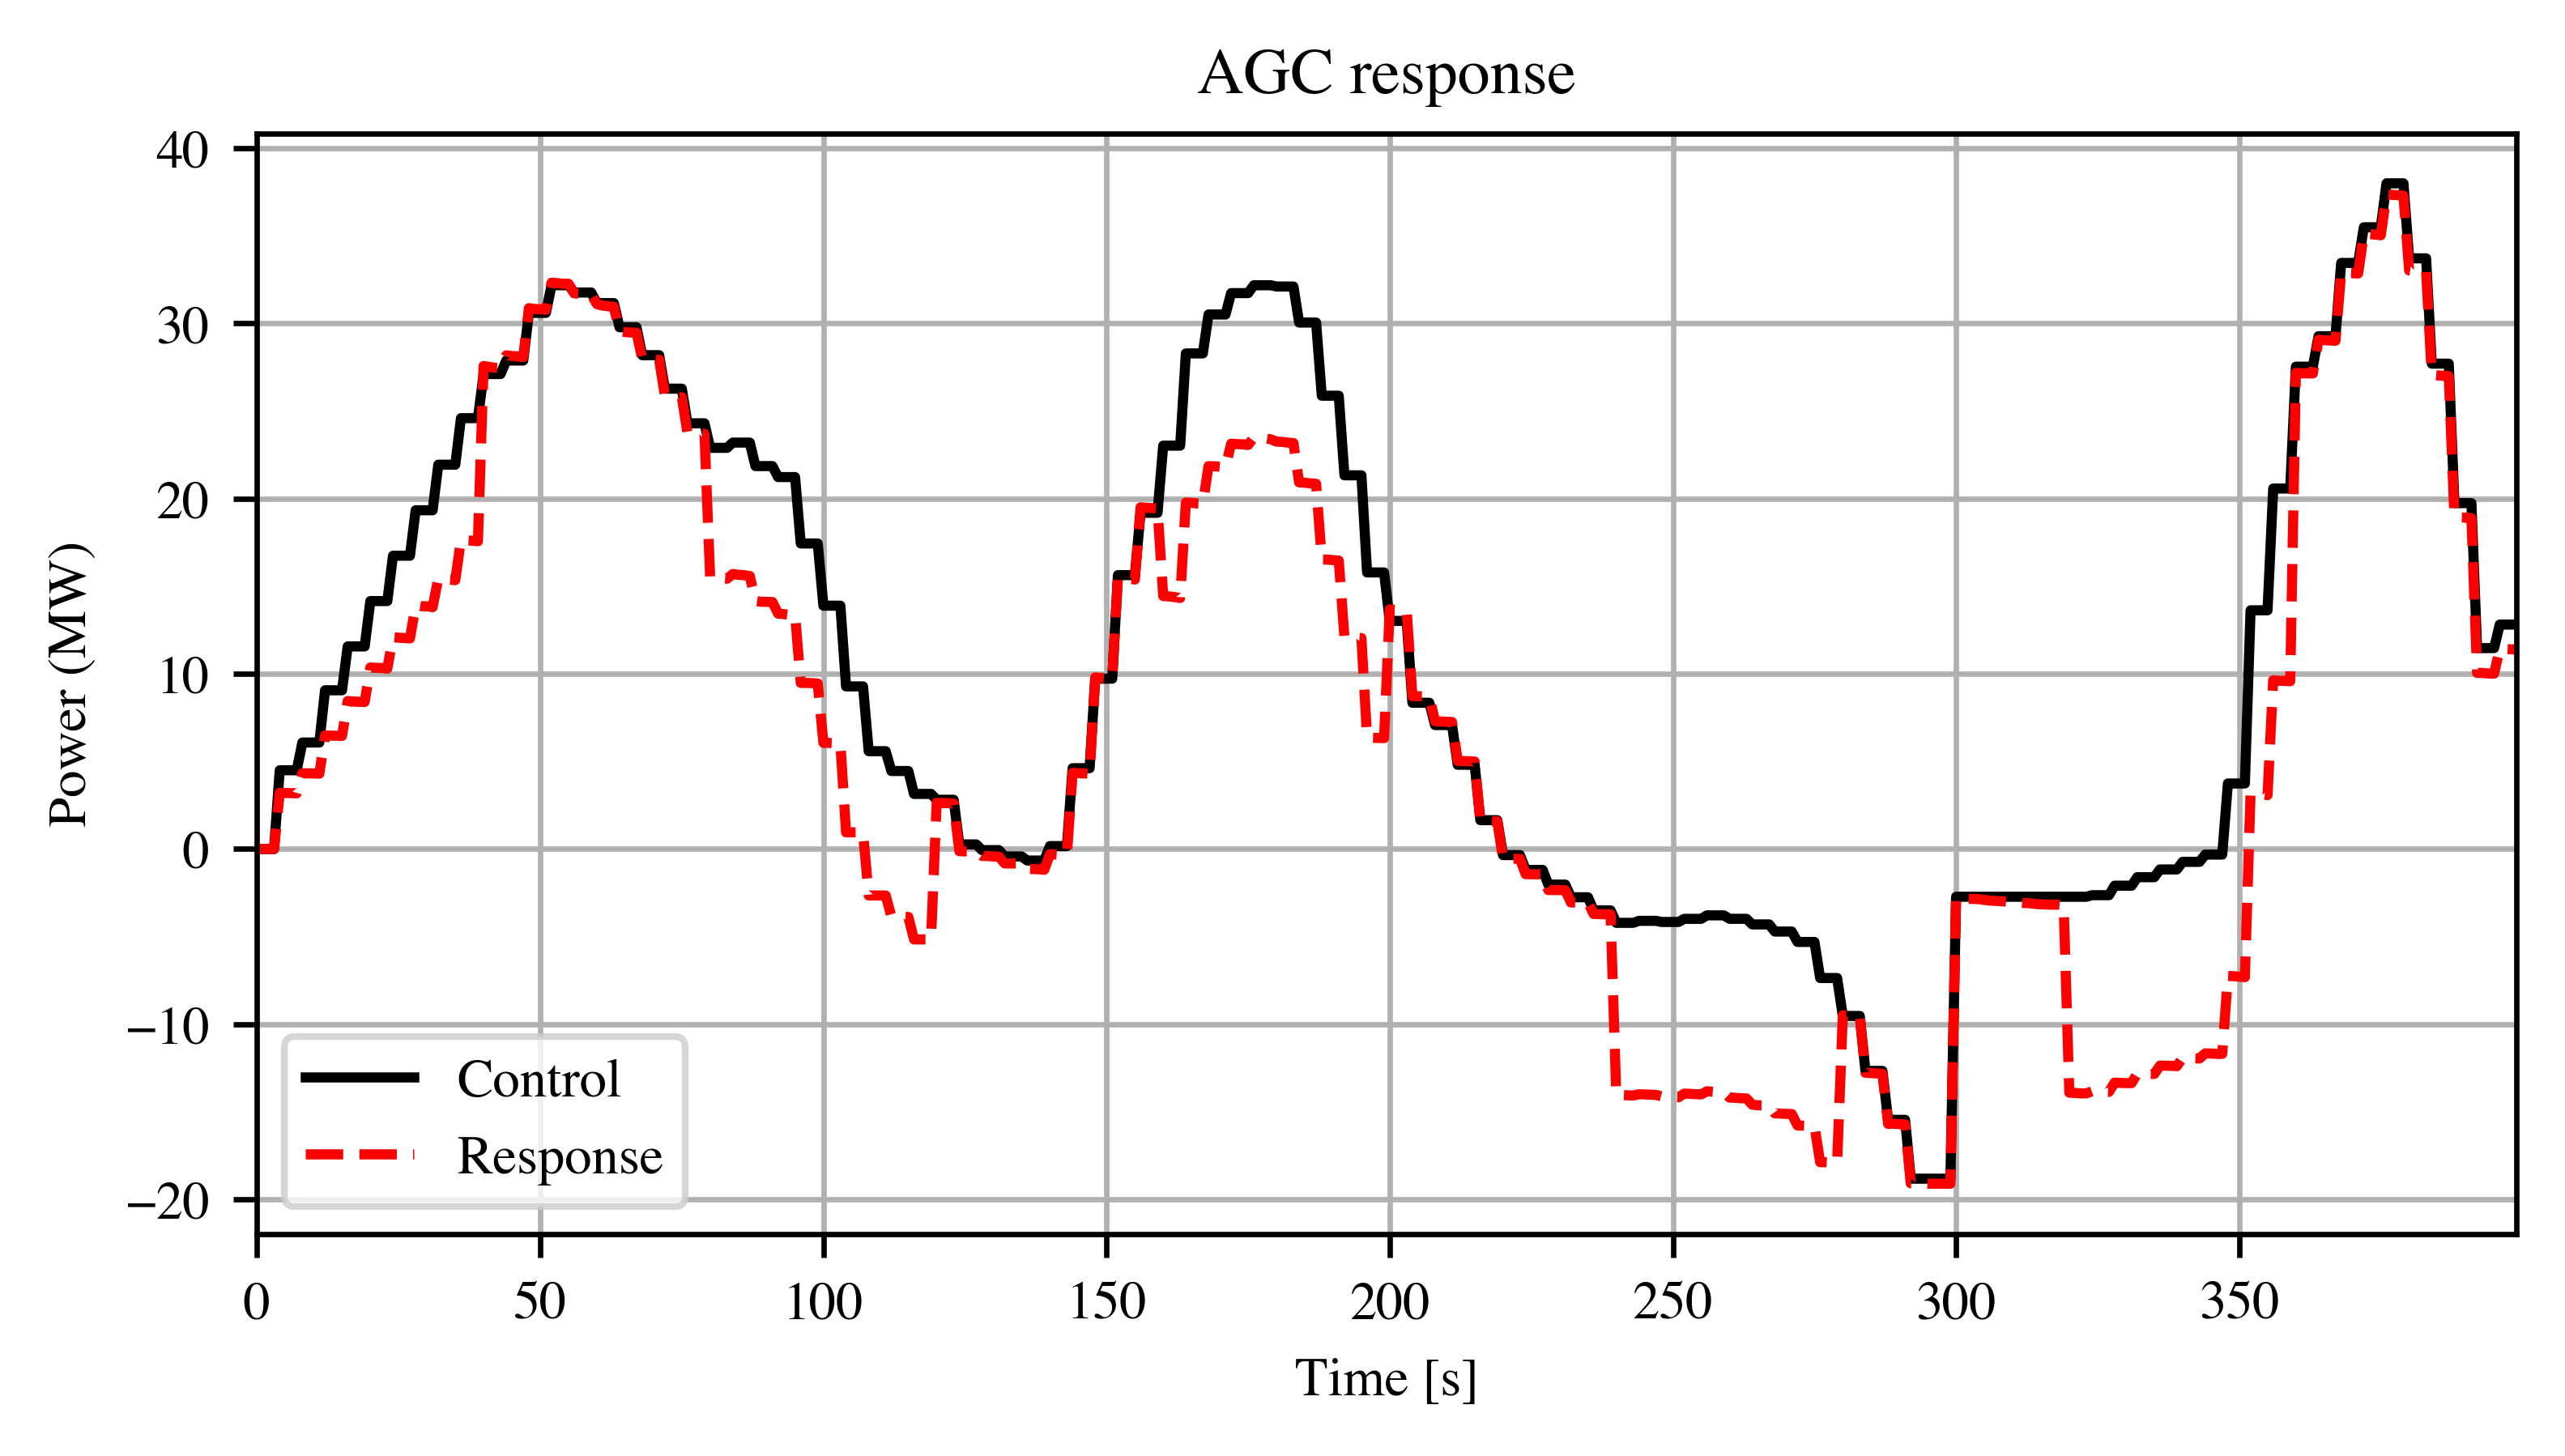

In [11]:
sse.plot_agc(style='ieee')

In [ ]:
sse.ev["tt"].hist(bins=30)

In [ ]:
sse.ict2(scaler=1)
sse.ev["ict"].hist(bins=30)
sse.ev["tt"].hist(bins=30)

In [ ]:
evc = sse.ev.copy()
evc['dna'] = evc['na'] - evc['na0']
evc['dna'].hist()

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
# split -l 4 index.txt split_file
# !ls -lh

plt.style.use('science')
%run -i 'cosim_plotev.py'